# Purpose

This notebook is where I will write and test the various metrics. My goals for this are as follows:
1. Fully Modular, Well-Documented functions
2. Takes in a List of Tuples: ('name', epitope:Structure, original_cdr:LinearStructure, predicted_cdr:LinearStructure)
    * These lists can be saved and loaded as .pkls so once I generate structures with a given model / settings, I never need to regenerate, I can just focus on evaluations
3. Outputs Relevant Top-Line Statistics to a Pandas Dataframe
4. Save histograms to a folder



In [4]:
import torch

In [1]:
# %env CUDA_VISIBLE_DEVICES=1
import os

# cuda_index = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = cuda_index
# print('set cuda device to: ' + cuda_index)

from itertools import permutations

import time
import plotly.graph_objects as go
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import sabdl
from loopgen.data import ReceptorLigandDataset
from loopgen.model import CDRFrameDataModule, CDRCoordinateDataModule, GVPSE3ScorePredictor, CDRCoordinateDiffusionModel, CDRFrameDiffusionModel, load_trained_model
from loopgen.nn.diffusion import SO3ReverseProcess, R3ReverseProcess
from loopgen.structure import Structure, OrientationFrames, LinearStructure, impute_CB_coords
from loopgen.utils import so3_exp_map, so3_log_map
from loopgen.model.utils import get_cdr_feature
from loopgen.visualisation import plot_structure

from sabdl.models.loss import StructureLoss
import seaborn as sns
from torch_scatter import scatter_mean
from scipy.spatial.distance import jensenshannon

from scipy.spatial import distance_matrix
from scipy.optimize import linear_sum_assignment

import pandas as pd

device = torch.device("cpu")
device

device(type='cpu')

# Setting Up

In [2]:
def frame_to_linear_struct(frames: OrientationFrames):
    """
    Converts OrientationFrames objects to LinearStructures.
    Makes 2 Major Assumptions:
        1. C_beta coords are imputed using tetrahedral geometry
        2. Since these frames do not contain any sequence information, 
           I arbitrarily assign the sequence to be all zeros, all alanines
    Input should only be one single OrientationFrames object where all frames belong to same underlying structure
    I'm not sure if the methods I rely on here play nicely with batches
    """
    N_coords, CA_coords, C_coords = frames.to_backbone_coords()
    CB_coords = impute_CB_coords(N_coords, CA_coords, C_coords)
    sequence = torch.zeros((len(N_coords)), dtype = torch.long)
    return LinearStructure(N_coords, CA_coords, C_coords, CB_coords, sequence=sequence)

In [3]:
def calculate_distances(points):
    if type(points) is not torch.Tensor:
        points = torch.Tensor(points)
    dist_arr = []
    for i in range(len(points)-1):
        start = points[i]
        finish = points[i+1]
        distance = torch.linalg.norm(start-finish, dim=0)
        dist_arr.append(distance.cpu().item())
#     print("end to end distance: ", torch.linalg.norm(points[-1]-points[0], dim = 0))
    return dist_arr

In [4]:
def pairwise_distance(tensor1, tensor2):
    """
    Compute the pairwise Euclidean distance between each point in tensor1 and any point in tensor2.

    Args:
        tensor1 (torch.Tensor): A PyTorch tensor of shape (n, 3), representing n 3D points with (x, y, z) coordinates.
        tensor2 (torch.Tensor): A PyTorch tensor of shape (m, 3), representing m 3D points with (x, y, z) coordinates.

    Returns:
        torch.Tensor: A 1D tensor of shape (n,), containing the shortest distances from each point in tensor1 to any point in tensor2.
    """
    tensor1_expanded = tensor1.unsqueeze(1)
    diff = tensor1_expanded - tensor2

    squared_distance = torch.sum(diff ** 2, dim=-1)

    min_distances, _ = torch.min(squared_distance, dim=-1)

    distances = torch.sqrt(min_distances)

    return distances

def order_points_linearly(points):
    """
    Orders a set of points in 3D space to form a linear chain.
    
    Args:
        points (numpy.ndarray): An nx3 array of points in 3D space.
        
    Returns:
        numpy.ndarray: An array of points representing the linearly ordered chain.
    """
    distances = np.linalg.norm(points[:, np.newaxis, :] - points, axis=-1)
    distances += np.eye(len(points))*100
    # Find the order that minimizes the cumulative distance
    order = np.argsort(np.sum(distances, axis=0))

    # Reorder the points
    
    
    return order

def order_points_linearly(points):
    """
    Finds the correct permutations to reorder a bunch of points using a modifed nearest neighbours algorithm.
    
    Returns the index
    """
    n = len(points)
    optimal_order = None
    min_total_distance = float('inf')

    for start_index in range(n):
        ordered_indices = [start_index]
        remaining_indices = list(range(0, start_index)) + list(range(start_index + 1, n))
        total_distance = 0

        while remaining_indices:
            last_index = ordered_indices[-1]
            distances = torch.linalg.norm(points[remaining_indices] - points[last_index], axis=1)
            nearest_index = remaining_indices[torch.argmin(distances)]
            ordered_indices.append(nearest_index)
            total_distance += distances[torch.argmin(distances)]
            remaining_indices.remove(nearest_index)

        if total_distance < min_total_distance:
            min_total_distance = total_distance
            optimal_order = ordered_indices

    return optimal_order

### Minor Checks that order_points_linearly works correctly

# Generating a Small List of Structures for Testing Metrics

In [38]:
def make_structures(gen_model, gen_datamodule, gen_dataset, batch_size: int = 500, reorder: bool = False):
    created_structures = []
    start = time.time()
    for start in range(0, len(gen_dataset), batch_size):
        
        structures = [gen_dataset[i] for i in range(start, min(start + batch_size, len(gen_dataset)))]
        gen_batch = gen_datamodule.collate(structures=structures)

        name_tup, epitope, original_cdr_batch = gen_batch

        torch.cuda.empty_cache() 
        with torch.no_grad():
            _, predicted_cdr_batch = gen_model.generate(gen_batch, noise_scale = torch.tensor(0.2), self_con = True);

        #Unpack the Structures and Orientation Frames, Convert Frames to LinearStructures, and add them to a list
        for i in range(len(structures)):
            ind_ptr = torch.tensor([0], dtype = torch.int)
            name = name_tup[i]
            epitope_ind = epitope[epitope.batch == i]
            cdr_ind_batch = torch.zeros(len(epitope_ind), device = device, dtype = torch.int)

            orig_cdr_coords = original_cdr_batch.translations[original_cdr_batch.batch == i]
            orig_cdr_rots = original_cdr_batch.rotations[original_cdr_batch.batch == i]

            pred_cdr_coords = predicted_cdr_batch.translations[predicted_cdr_batch.batch == i]
            pred_cdr_rots = predicted_cdr_batch.rotations[predicted_cdr_batch.batch == i]

            if reorder:
                pred_indices = order_points_linearly(pred_cdr_coords)
                pred_cdr_coords = pred_cdr_coords[pred_indices]
                pred_cdr_rots = pred_cdr_rots[pred_indices]

            orig_cdr_ind = OrientationFrames(orig_cdr_rots, orig_cdr_coords, batch = cdr_ind_batch, ptr = ind_ptr)
            pred_cdr_ind = OrientationFrames(pred_cdr_rots, pred_cdr_coords, batch = cdr_ind_batch, ptr = ind_ptr)

            orig_cdr_struct = frame_to_linear_struct(orig_cdr_ind)
            pred_cdr_struct = frame_to_linear_struct(pred_cdr_ind)
            
            ###Reorganize from N->C based on a constraint on the omegas. Only needed if reordering
            if reorder:
                omegas = torch.abs(pred_cdr_struct.get_backbone_dihedrals()[1:-1,1])
                if torch.any(omegas < 2):
                    pred_cdr_struct = pred_cdr_struct[torch.arange(len(pred_cdr_struct)-1,-1,-1)]
    
            created_structures.append(
                (
                    name, 
                    epitope_ind.to(torch.device("cpu")), 
                    orig_cdr_struct.to(torch.device("cpu")), 
                    pred_cdr_struct.to(torch.device("cpu"))
                )
            )

        del gen_batch, name_tup, epitope, original_cdr_batch, predicted_cdr_batch
        torch.cuda.empty_cache()
    print('Took {:4.2f} seconds to generate {} structures'.format(time.time()-start, len(created_structures)))
    return created_structures
# generated_structures = make_structures(1, 32, model, abag_datamodule, abag_dataset)

In [6]:
# new_ind = torch.arange(6,-1,-1)

In [7]:
# for i in range(len(generated_structures)):
#     print(generated_structures[i][3].get_backbone_dihedrals()[:,1])

In [8]:
# output = generated_structures[4]
# fig = plot_structure(output[1], backbone_colour = 'blue')
# plot_structure(output[2], backbone_colour = 'magenta', figure = fig)
# plot_structure(output[3], backbone_colour = 'orange', figure = fig)
# fig.write_image("../abdiff_results/nice_structures/abag_test_7.png", format="png")
# plot_coords_rots(output[3].orientation_frames.rotations, output[3].CA_coords, point_color = 'orange', fig = fig)

In [9]:
# generated_structures

In [10]:
# calculate_distances(output[3].orientation_frames.translations)

In [11]:
# print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(1)/1024/1024/1024))
# print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(1)/1024/1024/1024))
# print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(1)/1024/1024/1024))
# print("torch.cuda.memory_cached: %fGB"%(torch.cuda.memory_cached(1)/1024/1024/1024))

# Developing Metrics

In general, I want this to the functions to do the following:
1. Go through the list
2. For each entry, generate the metric for both the original thing and the predicted version

## Number of Clashes

In [12]:
def get_clashes(list_structs:list):
    struct_loss = StructureLoss()
    total_structs = len(list_structs)
    num_orig_struct_with_clashes = 0
    num_pred_struct_with_clashes = 0
    
    for i in range(total_structs):
        name, epitope, orig_cdr, pred_cdr = list_structs[i]
        orig_clash = struct_loss.get_clash_loss(orig_cdr)
        pred_clash = struct_loss.get_clash_loss(pred_cdr)
        
        if not torch.allclose(orig_clash, torch.zeros(len(orig_clash))):
            num_orig_struct_with_clashes += 1
        if not torch.allclose(pred_clash, torch.zeros(len(pred_clash))):
            num_pred_struct_with_clashes += 1
    
    return (num_orig_struct_with_clashes/total_structs, num_pred_struct_with_clashes/total_structs)

In [13]:
# get_clashes(generated_structures)

## Number of bond length violations

In [14]:
def get_bond_length_violations(list_structs:list):
    struct_loss = StructureLoss()
    total_structs = len(list_structs)
    num_orig_struct_with_bond_length_prob = 0
    num_pred_struct_with_bond_length_prob = 0
    
    for i in range(total_structs):
        
        name, epitope, orig_cdr, pred_cdr = list_structs[i]
        orig_bond_length_prob = struct_loss.get_bond_length_loss(orig_cdr)
        pred_bond_length_prob = struct_loss.get_bond_length_loss(pred_cdr)
        ####Bond Lengths are wrong at the C terminus b/c the chain has been 'cut' to be placed here
        # this causes and error where most structures have a violation on the last entry.
        # therefore, I remove the last element when conducting the rest of the analyses
        
#         print(orig_bond_length_prob)
        if not torch.allclose(orig_bond_length_prob, torch.zeros(len(orig_bond_length_prob))):
            num_orig_struct_with_bond_length_prob += 1
        if not torch.allclose(pred_bond_length_prob, torch.zeros(len(pred_bond_length_prob))):
            num_pred_struct_with_bond_length_prob += 1
    
    return (num_orig_struct_with_bond_length_prob/total_structs, num_pred_struct_with_bond_length_prob/total_structs)

In [15]:
# get_bond_length_violations(generated_structures)

## Number of Bond Angle Violations

In [16]:
def get_bond_angle_violations(list_structs:list):
    struct_loss = StructureLoss()
    total_structs = len(list_structs)
    num_orig_struct_with_bond_angle_prob = 0
    num_pred_struct_with_bond_angle_prob = 0
    
    for i in range(total_structs):
        
        name, epitope, orig_cdr, pred_cdr = list_structs[i]
        orig_bond_angle_prob = struct_loss.get_bond_angle_loss(orig_cdr)[:-1]
        pred_bond_angle_prob = struct_loss.get_bond_angle_loss(pred_cdr)[:-1]
        
        ####Bond Angles are imputed at the C terminus b/c the chain has been 'cut' to be placed here
        # this causes and error where most structures have a violation on the last entry.
        # therefore, I remove the last element when conducting the rest of the analyses
        
        if not torch.allclose(orig_bond_angle_prob, torch.zeros(len(orig_bond_angle_prob))):
            num_orig_struct_with_bond_angle_prob += 1
        if not torch.allclose(pred_bond_angle_prob, torch.zeros(len(pred_bond_angle_prob))):
            num_pred_struct_with_bond_angle_prob += 1
    
    return (num_orig_struct_with_bond_angle_prob/total_structs, num_pred_struct_with_bond_angle_prob/total_structs)

In [17]:
# get_bond_angle_violations(generated_structures)

## Clashes Between Epitope and CDR

Using a cutoff distance of 3.5, as I know that anything beyond that MUST be wrong

In [18]:
def compute_epitope_cdr_clashes(list_structs:list):
    
    pred_clashes = 0
    orig_clashes = 0
    total_structs = len(list_structs)
    for i in range(total_structs):
        name, epitope, orig_cdr, pred_cdr = list_structs[i]
        
        pred_distances = pairwise_distance(epitope.CA_coords, pred_cdr.CA_coords).numpy()
        orig_distances = pairwise_distance(epitope.CA_coords, orig_cdr.CA_coords).numpy()
        
        if np.any(pred_distances < 3.5): pred_clashes += 1
        if np.any(orig_distances < 3.5): orig_clashes += 1
    
    return orig_clashes/total_structs, pred_clashes/total_structs

# compute_epitope_cdr_clashes(generated_structures)

## Get % of Structures with Any Violation

In [19]:
def get_any_violation(list_structs:list):
    struct_loss = StructureLoss()
    total_structs = len(list_structs)
    num_orig_struct_with_any_viol = 0
    num_pred_struct_with_any_viol = 0
    
    for i in range(total_structs):
        
        name, epitope, orig_cdr, pred_cdr = list_structs[i]
        orig_bond_angle_prob = struct_loss.get_bond_angle_loss(orig_cdr)
        orig_bond_angle_prob[-1] = 0
        pred_bond_angle_prob = struct_loss.get_bond_angle_loss(pred_cdr)
        pred_bond_angle_prob[-1] = 0
        
        
        orig_bond_length_prob = struct_loss.get_bond_length_loss(orig_cdr)
        orig_bond_length_prob[-1] = 0
        pred_bond_length_prob = struct_loss.get_bond_length_loss(pred_cdr)
        pred_bond_length_prob[-1] = 0
        
        
        orig_clash = struct_loss.get_clash_loss(orig_cdr)
        pred_clash = struct_loss.get_clash_loss(pred_cdr)
        
        pred_distances = pairwise_distance(epitope.CA_coords, pred_cdr.CA_coords).numpy()
        orig_distances = pairwise_distance(epitope.CA_coords, orig_cdr.CA_coords).numpy()
       
        orig_all_violations = orig_bond_angle_prob + orig_bond_length_prob + orig_clash
        pred_all_violations = pred_bond_angle_prob + pred_bond_length_prob + pred_clash
        

        ####Bond Angles are imputed at the C terminus b/c the chain has been 'cut' to be placed here
        # this causes and error where most structures have a violation on the last entry.
        # therefore, I remove the last element when conducting the rest of the analyses
        
        if not torch.allclose(orig_all_violations, torch.zeros(len(orig_all_violations))):
            num_orig_struct_with_any_viol += 1
        elif np.any(orig_distances < 3.5):
            num_orig_struct_with_any_viol += 1
            
        if not torch.allclose(pred_all_violations, torch.zeros(len(pred_all_violations))):
            num_pred_struct_with_any_viol += 1
        elif np.any(pred_distances < 3.5):
            num_pred_struct_with_any_viol += 1

    return (num_orig_struct_with_any_viol/total_structs, num_pred_struct_with_any_viol/total_structs)

In [20]:
# get_any_violation(generated_structures)

## Get RMSD

In [21]:
def get_RMSD(cdr_orig_coords:LinearStructure, cdr_pred_coords:LinearStructure):
    """
    Only compares the C_alpha, b/c that is the underlying information in the OrientationFrames.
    The generated CDR, while in order of the chain, does not have any guarantees of forward or reverse
    So, I calculate both and then return the smallest.
    """
        
    #Easy to get forward
    forward_RMSD = torch.sqrt(torch.mean((cdr_orig_coords-cdr_pred_coords)**2))

    #For reverse, I need to first flip the direction of the structure. Notice use of .flip(0)
    reverse_RMSD = torch.sqrt(torch.mean((cdr_orig_coords-cdr_pred_coords.flip(0))**2))

    return min([forward_RMSD, reverse_RMSD])

def get_average_RMSD(list_structs:list):
    
    """
    Only compares the C_alpha, b/c that is the underlying information in the OrientationFrames.
    """
    total_structs = len(list_structs)
    rmsd_sum = 0.0
    rmsd_arr = []
    for i in range(total_structs):
        name, epitope, orig_cdr, pred_cdr = list_structs[i]
        
        rmsd_struct = get_RMSD(orig_cdr.CA_coords, pred_cdr.CA_coords)
        rmsd_sum += rmsd_struct.item()
        rmsd_arr.append(rmsd_struct.item())
    
    return rmsd_sum / total_structs, rmsd_arr

def get_average_RMSD_random(list_structs):
    """
    This function feeds a completely random CDR from the list and computes the RMSD with the original.
    This is a check to see if there is any signal from the epitope in what the model generates
    """
    struct_loss = StructureLoss()
    total_structs = len(list_structs)
    rmsd_sum = 0
    rmsd_arr = []
    for i in range(total_structs):
        
        orig_name, _, orig_cdr, _ = list_structs[i]
        
        
        #Must find a CDR with the same number of residues...
        ctr = 0
        found_match = True
        random_integer = torch.randint(0, total_structs, (1,))[0]
        random_name, _, _, pred_cdr = list_structs[random_integer]
        while (len(pred_cdr.CA_coords) != len(orig_cdr.CA_coords) or orig_name == random_name):
            ctr += 1
            random_integer = torch.randint(0, total_structs, (1,))[0]
            random_name, _, _, pred_cdr = list_structs[random_integer]
#             if ctr % 100 == 0 and ctr >99: print(ctr)
            if ctr >= 1000:
                print("couldn't find match for:", orig_name, "with length", len(orig_cdr),".Excluded from analysis")
                found_match = False
                break
                
        if not found_match: #skip any entry where a match isn't found in 1000 iterations, 
            continue  
        
        rmsd_struct = get_RMSD(orig_cdr.CA_coords, pred_cdr.CA_coords)
        rmsd_sum += rmsd_struct.item()
        rmsd_arr.append(rmsd_struct.item())
        
    return rmsd_sum / total_structs, rmsd_arr
    

def generate_rmsd_comparison(list_structs: list):
    
    real_avg, real_arr = get_average_RMSD(list_structs)
    random_avg, random_arr = get_average_RMSD_random(list_structs)
    print('Average RMSD: {:4.2f}'.format(real_avg))
    
    fig, ax = plt.subplots()
    sns.histplot(real_arr, stat='density', alpha=0.4, binrange = (0, 7), bins = 25, label='Real Prediction', element='step')
    sns.histplot(random_arr, stat='density', alpha = 0.4, binrange = (0, 10), bins = 25, label = 'Scrambled Prediction', element='step');
    ax.legend(loc = 'upper right')
    ax.set_xlabel('RMSD ($\\AA$)')
    ax.set_ylabel('Density')
    
    return fig, real_avg, np.std(real_arr)


# generate_rmsd_comparison(generated_structures)

# Ramachandran Distribution

In [22]:
def make_ramachandran_plot(list_structs:list):
    
    """
    Note that the angles obviously don't exist on the ends of the structure, 
    but the function Matt wrote incorporates them. To remove these 
    artifacts, I ignore the first and last coordinates (hence the [1:-1, X])
    """
    total_structs = len(list_structs)
    
    orig_phi_arr = []
    orig_omega_arr = []
    orig_psi_arr = []
    
    pred_phi_arr = []
    pred_omega_arr = []
    pred_psi_arr = []
    
    for i in range(total_structs):
        name, epitope, orig_cdr, pred_cdr = list_structs[i]
        
        
        orig_angles = orig_cdr.get_backbone_dihedrals()
        orig_phi = orig_angles[1:-1,0]
        orig_omega = orig_angles[1:-1,1]
        orig_psi = orig_angles[1:-1,2]
        
        pred_angles = pred_cdr.get_backbone_dihedrals()
        pred_phi = pred_angles[1:-1,0]
        pred_omega = pred_angles[1:-1,1]
        pred_psi = pred_angles[1:-1,2]
        
        orig_phi_arr += orig_phi.numpy().tolist()
        orig_omega_arr += orig_omega.numpy().tolist()
        orig_psi_arr += orig_psi.numpy().tolist()
        
        pred_phi_arr += pred_phi.numpy().tolist()
        pred_omega_arr += pred_omega.numpy().tolist()
        pred_psi_arr += pred_psi.numpy().tolist()
    
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    ax1.plot(orig_phi_arr[::], orig_psi_arr[::], '.', alpha=0.4, label='Real')
    ax1.plot(pred_phi_arr[::], pred_psi_arr[::], '.', alpha=0.4, label='Generated')

    ax1.legend(loc='upper left')
    ax1.set_xlabel('$\\phi$')
    ax1.set_ylabel('$\\psi$')

    ax1.set_xlim(-np.pi,np.pi)
    ax1.set_ylim(-np.pi,np.pi)

    ax1.set_aspect('equal')
    
    ax1.axhline(y=0, color='black', linewidth=0.8)  # Add horizontal axis
    ax1.axvline(x=0, color='black', linewidth=0.8)  # Add vertical axis
    
    plt.grid(True, linestyle='--', alpha=0.2)  # Add grid lines
#     ax1.set_title('Ramachandran Distribution')  # Add a title
    fig1.tight_layout()
    return fig1
    
# make_ramachandran_plot(generated_structures)

# Make Histogram of Distances to Epitope

In [23]:
def make_epitope_distance_histograms(list_structs:list):
    
    all_pred_distances = []
    all_orig_distances = []
    
    min_pred_distances = []
    min_orig_distances = []
    
    
    total_structs = len(list_structs)
    for i in range(total_structs):
        
        name, epitope, orig_cdr, pred_cdr = list_structs[i]
        
        pred_distances = pairwise_distance(pred_cdr.CA_coords, epitope.CA_coords).numpy().tolist()
        orig_distances = pairwise_distance(orig_cdr.CA_coords, epitope.CA_coords).numpy().tolist()

        all_pred_distances += pred_distances
        all_orig_distances += orig_distances
        
        min_pred_distances.append(np.min(pred_distances))
        min_orig_distances.append(np.min(orig_distances))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Create a new figure with two subplots
    
    sns.histplot(all_orig_distances, stat='density', binrange = (0,25), cumulative=False, alpha=0.5, label='Real', ax=ax1, element='step')
    sns.histplot(all_pred_distances, stat='density', binrange = (0,25), cumulative=False, alpha=0.5, label='Generated', ax=ax1, element='step')
    
    sns.histplot(min_orig_distances, binrange = (0,15), stat='density', cumulative=False, alpha=0.5, label='Real', ax=ax2, element='step')
    sns.histplot(min_pred_distances, binrange = (0,15), stat='density', cumulative=False, alpha=0.5, label='Generated', ax=ax2, element='step')
    
    # Add labels and title to the first subplot
    ax1.set_xlabel('Minimum Distance from Each CDR Residue to Epitope (Å)')
    ax1.set_ylabel('Normalized Frequency')
    ax1.legend()
    
    # Add labels and title to the second subplot
    ax2.set_xlabel('Minimum Distance From Closest CDR Residue to Epitope (Å)')
    ax2.set_ylabel('Normalized Frequency')
    ax2.legend()
    
    
    orig_prob, _ = np.histogram(all_orig_distances, range = (3.5, 15), bins=14)
    pred_prob, _ = np.histogram(all_pred_distances, range = (3.5, 15), bins=14)
    all_jensenshannon = jensenshannon(orig_prob,pred_prob)
#     print(all_jensenshannon)
   
    min_orig_prob, _ = np.histogram(min_orig_distances, range = (3.5, 9), bins=10)
    min_pred_prob, _ = np.histogram(min_pred_distances, range = (3.5, 9), bins=10)
    
    min_jensenshannon = jensenshannon(min_orig_prob,min_pred_prob)
#     print(min_jensenshannon)
    
    
    return fig, all_jensenshannon, min_jensenshannon  # Return the figure object



# Your list of generated structures
# fig, _, _ = make_epitope_distance_histograms(generated_structures)
# plt.show()

# Comparing the MSM Entropy (only do for abaglike)

In [24]:
def get_shannon_entropies(prediction, collation):
    
    prob_vector = F.softmax(prediction, dim=1)
    shannon_entropy = scatter_mean(
        -torch.sum(prob_vector * torch.log(prob_vector), dim=1),
        collation[3]["ligand"].batch,
        dim=0
    )
    
    return torch.mean(shannon_entropy).item(), shannon_entropy.cpu().detach().numpy().tolist()


def get_msm_evaluation(generated_structures: list):
    
    msm_datamodule, msm_model = load_trained_model(
    CDRMaskedSequenceGVPModel, 
    "/spinning1/sharedby/jdb206/msm_abaglike_ic/best_weights.ckpt", 
    "/spinning1/sharedby/jdb206/train_abaglike_ic_for_abdiff_eval.yaml",
    )

    msm_model.to(device)
    msm_model.eval();
    
    real_cdr_batch = [(item[0], item[1], item[2]) for item in generated_structures]
    pred_cdr_batch = [(item[0], item[1], item[3]) for item in generated_structures]

    real_cdr_collation = msm_datamodule.collate(real_cdr_batch)
    pred_cdr_collation = msm_datamodule.collate(pred_cdr_batch)

    with torch.no_grad():
        real_msm = msm_model.forward(real_cdr_collation[3].to(device), real_cdr_collation[2].to(device))
        pred_msm = msm_model.forward(pred_cdr_collation[3].to(device), pred_cdr_collation[2].to(device))
    
    
    fig, ax = plt.subplots(num=0)
    
    real_avg, real_entropy_arr = get_shannon_entropies(real_msm, real_cdr_collation)
    pred_avg, pred_entropy_arr = get_shannon_entropies(pred_msm, pred_cdr_collation)

    sns.histplot(real_entropy_arr, stat='density', alpha=0.4, bins = 25, label='Real CDRs', element='step')
    sns.histplot(pred_entropy_arr, stat='density', alpha = 0.4, bins = 25, label = 'Generated CDRs', element='step');
    ax.legend()
    ax.set_xlabel('Entropy (nats)')
    ax.set_ylabel('Normalized Frequency')
    
#     print('Real Average Entropy: ', real_avg)
#     print('Generated Average Entropy: ', pred_avg)
    
    return fig, pred_avg, np.std(pred_entropy_arr)

# get_msm_evaluation(generated_structures)

# Comparing the Principal Components of Point Cloud

First doing a visual verification below, then I'll write a nicer function to package things

Note that I'm using SVD to get the orthonormal eigenvectors in VT with the eigenvalues in S. However, in this case scale is important, so I am rescaling the columns of VT using the corresponding eigenvalue.

In [25]:
# generated_structures[0]

In [26]:
# coords = generated_structures[0][2].CA_coords

In [27]:
# U, S, VT = torch.linalg.svd(coords)

# print("U:", U)
# print("S:", S)
# print("VT:", VT)

In [28]:
# import numpy as np
# import plotly.graph_objects as go

# # Replace this with your actual Nx3 tensor of points

# # Perform SVD
# U, S, VT = np.linalg.svd(coords)

# # Create a scatter plot for the points
# scatter = go.Scatter3d(x=coords[:, 0], y=coords[:, 1], z=coords[:, 2], mode='markers', name='Points')

# # Create coordinate axes based on VT
# origin = np.zeros(3)
# axis_x = VT[0, :] * S[0]
# axis_y = VT[1, :] * S[1]
# axis_z = VT[2, :] * S[2]

# axes = [
#     go.Scatter3d(x=[origin[0], axis_x[0]], y=[origin[1], axis_x[1]], z=[origin[2], axis_x[2]], mode='lines', name='Axis X'),
#     go.Scatter3d(x=[origin[0], axis_y[0]], y=[origin[1], axis_y[1]], z=[origin[2], axis_y[2]], mode='lines', name='Axis Y'),
#     go.Scatter3d(x=[origin[0], axis_z[0]], y=[origin[1], axis_z[1]], z=[origin[2], axis_z[2]], mode='lines', name='Axis Z')
# ]

# # Create the plot layout
# layout = go.Layout(scene=dict(aspectmode='data'))

# # Create the figure
# fig = go.Figure(data=[scatter, *axes], layout=layout)

# # Show the plot
# fig.show()

In [29]:
def get_svd_vectors(points, scaled = True):
    U, S, VT = torch.linalg.svd(points)
    if scaled:
        vec1 = VT[0, :] * S[0]
        vec2 = VT[1, :] * S[1]
        vec3 = VT[2, :] * S[2]
    else:
        vec1 = VT[0, :]
        vec2 = VT[1, :]
        vec3 = VT[2, :]
    return (vec1, vec2, vec3)


def compare_svd(points_A: torch.Tensor, points_B: torch.Tensor, scaled = True):
    
    vectors_A = get_svd_vectors(points_A, scaled)
    vectors_B = get_svd_vectors(points_B, scaled)
    
    dot_sum = 0
    for i in range(1):
        dot_sum += torch.dot(vectors_A[i], vectors_B[i])
    
    return torch.abs(dot_sum)

In [30]:
def get_average_svd_similarity(list_structs:list):
    
    """
    Only compares the C_alpha, b/c that is the underlying information in the OrientationFrames.
    """
    total_structs = len(list_structs)
    svd_total = 0
    svd_arr = []
    for i in range(total_structs):
        name, epitope, orig_cdr, pred_cdr = list_structs[i]
        
        svd_sim = compare_svd(orig_cdr.CA_coords, pred_cdr.CA_coords, scaled = False)
        svd_total += svd_sim.item()
        svd_arr.append(svd_sim.item())
    
    return svd_total / total_structs, svd_arr

def get_average_SVD_sim_random(list_structs):
    """
    This function feeds a completely random CDR from the list and computes the RMSD with the original.
    This is a check to see if there is any signal from the epitope in what the model generates
    """
    total_structs = len(list_structs)
    svd_total = 0
    svd_arr = []
    for i in range(total_structs):
        
        orig_name, _, orig_cdr, _ = list_structs[i]
        
        
        #Must find a CDR with the same number of residues...
        random_integer = torch.randint(0, total_structs, (1,))[0]
        random_name, _, _, pred_cdr = list_structs[random_integer]
        
        ctr = 0
        found_match = True
        while (len(pred_cdr.CA_coords) != len(orig_cdr.CA_coords) or orig_name == random_name):
            ctr += 1
            random_integer = torch.randint(0, total_structs, (1,))[0]
            random_name, _, _, pred_cdr = list_structs[random_integer]
#             if ctr % 100 == 0 and ctr >99: print(ctr)
            if ctr >= 1000:
                print("couldn't find match for:", orig_name, "with length", len(orig_cdr),".Excluded from analysis")
                found_match = False
                break
                
        if not found_match: #skip any entry where a match isn't found in 1000 iterations, 
            continue        #AKA there is no meaningful randomization
        svd_sim = compare_svd(orig_cdr.CA_coords, pred_cdr.CA_coords, scaled = False)
        svd_total += svd_sim.item()
        svd_arr.append(svd_sim.item())
        
    return svd_total / total_structs, svd_arr


def get_svd_comparison(generated_structures:list):
    
    real_avg, real_arr = get_average_svd_similarity(generated_structures)
    random_avg, random_arr = get_average_SVD_sim_random(generated_structures)
    
    fig_svd, ax_svd = plt.subplots()
#     fig_svd.clf()
    sns.histplot(real_arr, label = 'Real Prediction',stat = 'density', bins = 40, alpha = 0.5, element='step');
    sns.histplot(random_arr, label = 'Randomized Prediction', stat = 'density', bins = 40, alpha = 0.5, element='step');
    ax_svd.set_xlabel('Magnitude of Cosine Similarity')
    ax_svd.legend(loc = 'upper left')
    return fig_svd, real_avg, np.std(real_arr)

# get_svd_comparison(generated_structures)

# Putting Everything Together!

In [36]:
def run_analysis(exp_name, model, datamodule, dataset, dataset_name, analysis_model_path, analysis_yaml_path):
    
    assert dataset_name == "sabdab" or dataset_name == "abaglike_ic", "unexpected dataset name"
    
    abdiff_results_folder = '../abdiff_results/'
    
    model_results_folder = os.path.join(abdiff_results_folder, exp_name)
    
    if not os.path.exists(model_results_folder): 
        os.mkdir(model_results_folder)
        
    model_and_dataset_results_folder = os.path.join(model_results_folder, dataset_name)
    
    if not os.path.exists(model_and_dataset_results_folder): 
        os.mkdir(model_and_dataset_results_folder)
    else:
        print('WARNING! Folder has already been created and you may be overwriting previous results')
    
    print('Generating Structures. This will take a few minutes:...')
    generated_structures = make_structures(model, datamodule, dataset)
    
    
    real_clashes, pred_clashes = get_clashes(generated_structures)
    real_bond_length_viol, pred_bond_length_viol = get_bond_length_violations(generated_structures)
    real_bond_angle_viol, pred_bond_angle_viol = get_bond_angle_violations(generated_structures)
    orig_cdr_epitope_clashes, pred_cdr_epitope_clashes = compute_epitope_cdr_clashes(generated_structures)
    orig_any_viol, pred_any_viol = get_any_violation(generated_structures)
    rmsd_fig, rmsd_avg, rmsd_std = generate_rmsd_comparison(generated_structures)
    ramachandran_fig = make_ramachandran_plot(generated_structures)
    dist_hist_fig, all_jensenshannon, min_jensenshannon = make_epitope_distance_histograms(generated_structures)  
    svd_fig, svd_avg, svd_std = get_svd_comparison(generated_structures)

    #Save Figures:
    rmsd_path = os.path.join(model_and_dataset_results_folder ,'RMSD_comparison.png')
    ramachandran_path = os.path.join(model_and_dataset_results_folder ,'Ramachandran.png')
    dist_hist_path = os.path.join(model_and_dataset_results_folder ,'Dist_hist.png')
    svd_path = os.path.join(model_and_dataset_results_folder ,'SVD_comparison.png')
    
    rmsd_fig.savefig(rmsd_path, dpi = 200)
    ramachandran_fig.savefig(ramachandran_path, dpi = 200)
    dist_hist_fig.savefig(dist_hist_path, dpi = 200)
    svd_fig.savefig(svd_path, dpi = 200)
    
    #Add into dictionary
    results_dict = {}
    results_dict["Model Name"] = exp_name
    results_dict["Dataset"] = dataset_name
    results_dict["Model Path"] = analysis_model_path
    results_dict["Yaml Path"] = analysis_yaml_path
    results_dict["Internal Clashes"] = pred_clashes
    results_dict["Bond Length Violations"] = pred_bond_length_viol
    results_dict["Bond Angle Violations"] = pred_bond_angle_viol
    results_dict["Epitope-CDR Clashes"] = pred_cdr_epitope_clashes
    results_dict["Any Structural Flaw"] = pred_any_viol
    results_dict["RMSD Average"] = rmsd_avg
    results_dict["RMSD Stdev"] = rmsd_std
    results_dict["All Residue Jensen-Shannon Distance"] = all_jensenshannon
    results_dict["Closest Residue Jensen-Shannon Distance"] = min_jensenshannon
    results_dict["Magnitude of Cosine Similarity Mean"] = svd_avg
    results_dict["Magnitude of Cosine Similarity Stdev"] = svd_std
    
    
    csv_name = exp_name + '_' + dataset_name +'.csv'
    specific_df = pd.DataFrame([results_dict])
    csv_path = os.path.join(model_and_dataset_results_folder, csv_name)  # Specify the path where you want to save the CSV file
    specific_df.to_csv(csv_path, index=False)  # Set index=False to exclude the index column
    
    path_to_all_dataset_csv = os.path.join('../abdiff_results', dataset_name + '_all_results.csv')
    
    if os.path.exists(path_to_all_dataset_csv):
        all_df = pd.read_csv(path_to_all_dataset_csv)
        result_df = pd.concat([all_df, specific_df], ignore_index=True)
    else:
        result_df = specific_df
        
        
    result_df.to_csv(path_to_all_dataset_csv, index=False)
        
    
    return specific_df
    
    

In [32]:
def analyze_model(exp_name, model, sabdab_dataset, abag_dataset, 
                  sabdab_datamodule, abag_datamodule, model_path, yaml_path):
    run_analysis(exp_name, model, sabdab_datamodule, sabdab_dataset, "sabdab", model_path, yaml_path)
    run_analysis(exp_name, model, abag_datamodule, abag_dataset, "abaglike_ic", model_path, yaml_path)

In [3]:
start = time.time()

model_path = "../data/best_weights-epoch=215-validation_loss=0.78.ckpt"
yaml_path = "../config/train_finetuning_sabdab.yaml"


# abag_datamodule, model = load_trained_model(
#     CDRFrameDiffusionModel,
#     model_path,
#     yaml_path,
#     "/spinning1/sharedby/mg989/datasets/abaglike_ic.hdf5",
#     device=device
# )
#
#
# abag_datamodule.setup('fit') #loads train test splits according to specification in yaml
# abag_dataset = abag_datamodule.test_dataset #Only use test on AbAg, according to the split specified in yaml and
#                                             #Initialized in the .setup()

sabdab_datamodule, model = load_trained_model(
    CDRFrameDiffusionModel, 
    model_path, 
    yaml_path,
    "../data/sabdab_90b.hdf5",
    "../data/sabdab_splits.json",
    device=device
)


###use below when trained on sabdab. make sure that yaml is specified correctly, and that the yaml is different
# for sabdab and abag if using pretrained on abag
sabdab_datamodule.setup('fit')
sabdab_dataset = sabdab_datamodule.test_dataset

model.eval()
model = model.to(device)
print('Model Path: ', model_path)
print('Yaml Path: ', yaml_path)
print('Loaded models and datamodules in {:4.2f} seconds'.format(time.time()-start))
if model.training:
    print('Warning: Model is currently not in eval mode, so predictions will vary due to changes in batch norm')
else:
    print('Model is in eval mode')

/Users/matt/opt/anaconda3/envs/sabdl/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.2, which is newer than your current Lightning version: v2.0.1
  rank_zero_warn(


Model Path:  ../data/best_weights-epoch=215-validation_loss=0.78.ckpt
Yaml Path:  ../config/train_finetuning_sabdab.yaml
Loaded models and datamodules in 3.19 seconds
Model is in eval mode


WARNING! Folder has already been created and you may be overwriting previous results
Generating Structures. This will take a few minutes:...
Took 1694864006.68 seconds to generate 687 structures
Average RMSD: 2.48
Generating Structures. This will take a few minutes:...
Took 1694860548.29 seconds to generate 5396 structures
Average RMSD: 2.62
couldn't find match for: /4aoy/4aoy_pair_45 with length 11 .Excluded from analysis
couldn't find match for: /4fym/4fym_pair_419 with length 11 .Excluded from analysis


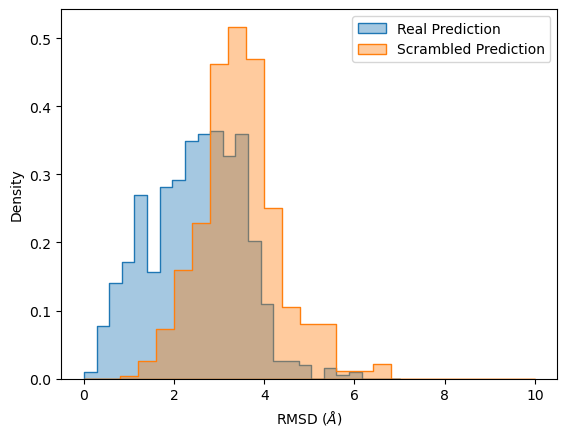

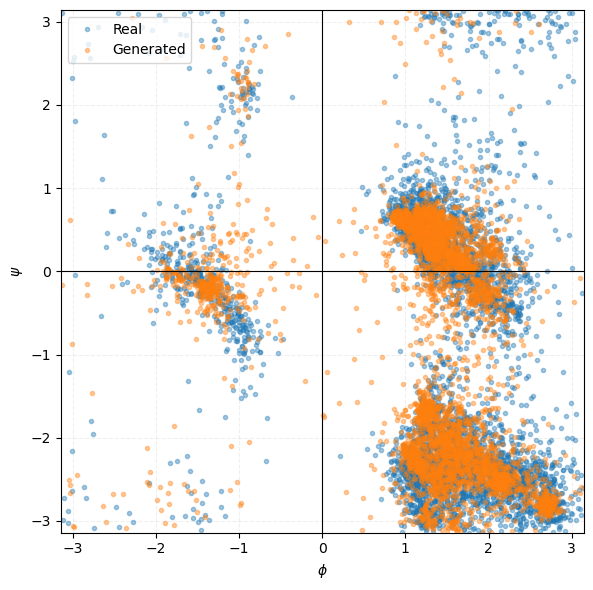

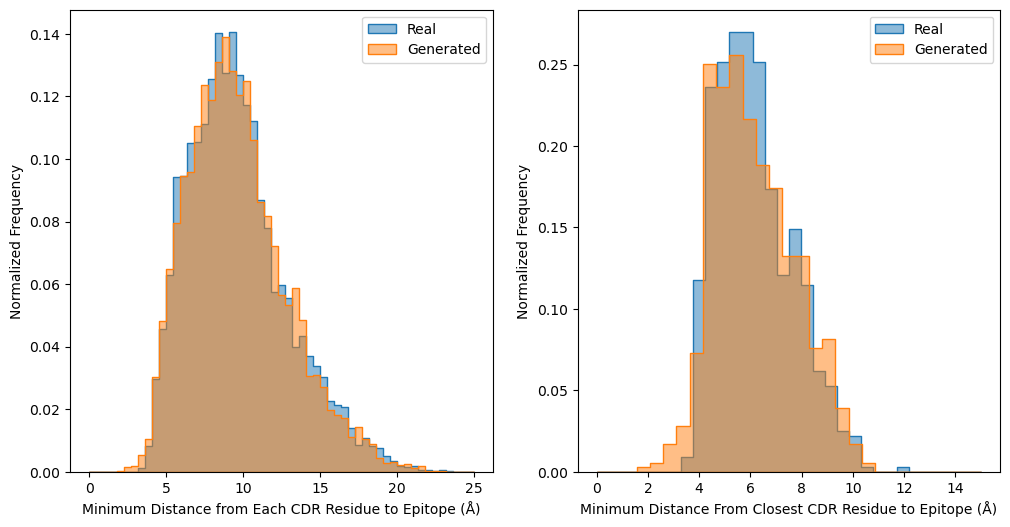

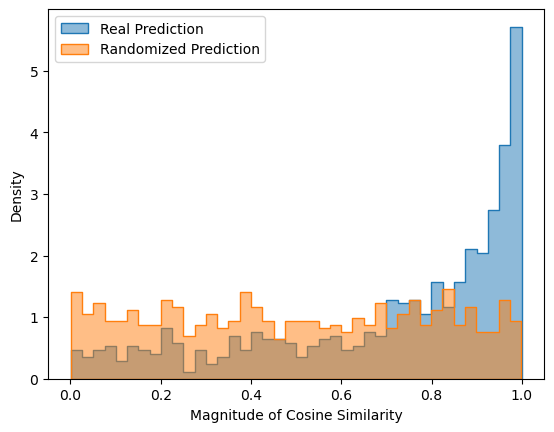

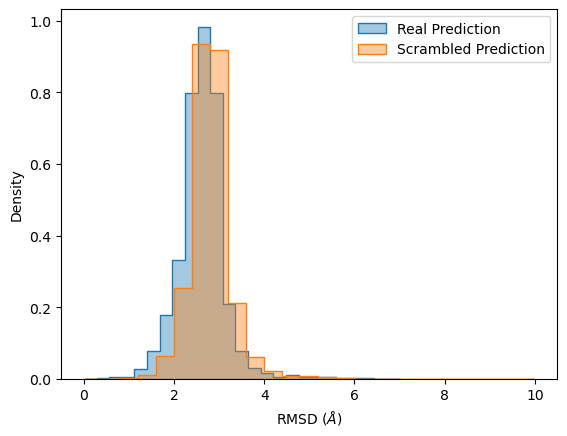

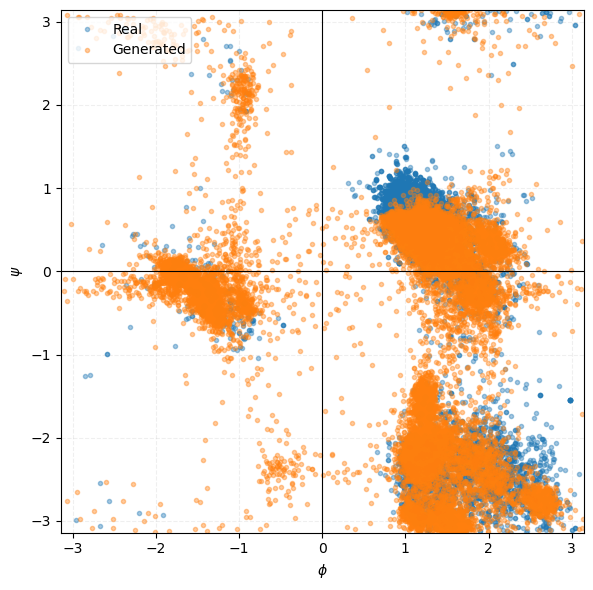

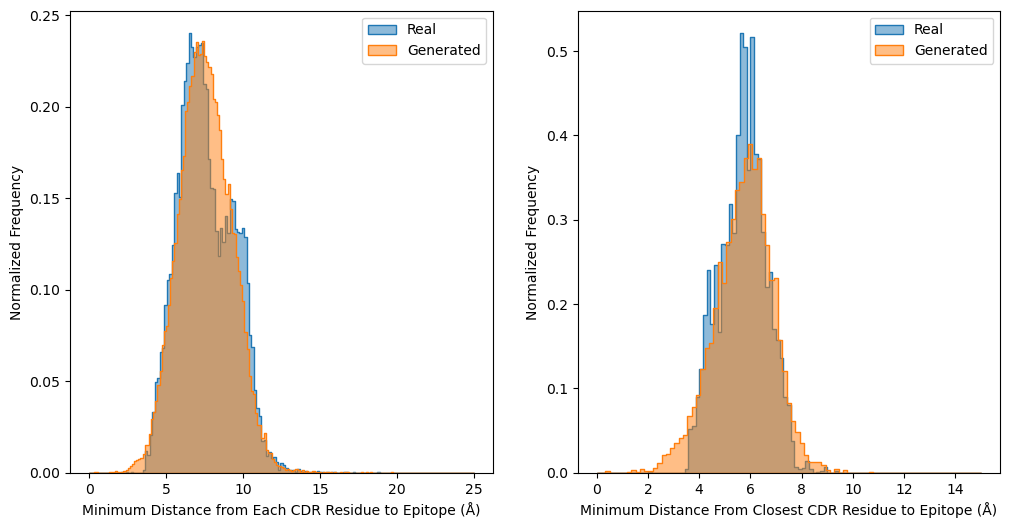

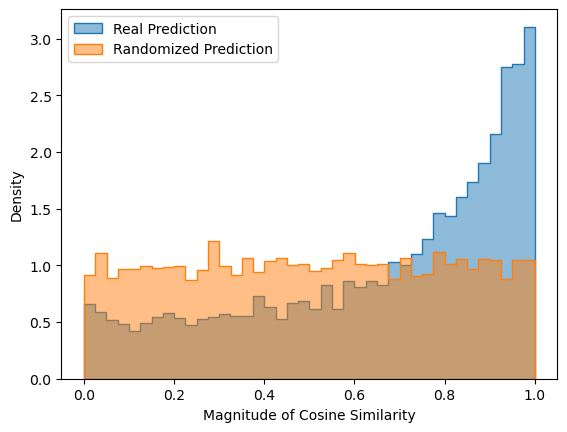

In [39]:
analyze_model('sabdab_finetuned', 
              model, 
              sabdab_dataset, 
              abag_dataset, 
              sabdab_datamodule, 
              abag_datamodule, 
              model_path, 
              yaml_path)